[View in Colaboratory](https://colab.research.google.com/github/wns349/gostop-card-detector/blob/master/Go_Stop_Card_Object_Detection.ipynb)

# Go-Stop Card Object Detection

## Download required libraries and github modules

In [1]:
# remove sample_data since we do not need it
!rm -rf ./sample_data
# clone github projects
!git clone https://github.com/hardikvasa/google-images-download
!git clone https://github.com/wns349/gostop-card-detector.git
!git clone https://github.com/wns349/tensorflow-yolo.git
# install pip requirements
!pip install imgaug tqdm opencv_python scikit_learn
# download pre-trained yolo weights for neural network training
!wget https://pjreddie.com/media/files/yolov2.weights

Cloning into 'google-images-download'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 443 (delta 0), reused 0 (delta 0), pack-reused 442
Receiving objects: 100% (443/443), 213.22 KiB | 405.00 KiB/s, done.
Resolving deltas: 100% (242/242), done.
Cloning into 'gostop-card-detector'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 72 (delta 2), reused 72 (delta 2), pack-reused 0
Unpacking objects: 100% (72/72), done.
Cloning into 'tensorflow-yolo'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 272 (delta 11), reused 15 (delta 7), pack-reused 248
Receiving objects: 100% (272/272), 4.95 MiB | 374.00 KiB/s, done.
Resolving deltas: 100% (133/133), done.
    100% |████████████████████████████████| 634kB 23.2MB/s 
  Running setup.py bdist_whe

## Preparing dataset

### Download random background images from the web

We use `https://github.com/hardikvasa/google-images-download` to download random images from Google.

Downloaded images are stored in `./bg/`

In [2]:
# download 50 'pattern' images
!python ./google-images-download/google_images_download/google_images_download.py --keywords "pattern" --format "jpg" --type "photo" --output_directory ./bg/ --limit 50


Item no.: 1 --> Item name = pattern
Evaluating...
Starting Download...
Completed Image ====> 1. gray-polygonal-background-picture-id514230814?k=6&m=514230814&s=612x612&w=0&h=siamfonk2nq_q3jwy5nlbmvlkkz9ta_rwc6aedamjty=.jpg
Completed Image ====> 2. xshutterstock_407554567.jpg
Completed Image ====> 3. ayyij.jpg
Completed Image ====> 4. photo-1491895200222-0fc4a4c35e18?ixlib=rb-0.3.5&ixid=eyjhchbfawqiojeymdd9&s=7ef79a01f0a12450049b7d20cd10f93c&w=1000&q=80.jpg
Completed Image ====> 5. lea-maupetit-rice-pattern.jpg
Completed Image ====> 6. b.jpg
Completed Image ====> 7. photo-1518640467707-6811f4a6ab73?ixlib=rb-0.3.5&ixid=eyjhchbfawqiojeymdd9&s=5e13608bf6071802b8df2c54c5205213&w=1000&q=80.jpg
Completed Image ====> 8. modern-seamless-pattern-vector-illustration_53876-26125.jpg
Completed Image ====> 9. vector-seamless-black-white-irregular-260nw-375468052.jpg
Completed Image ====> 10. 28-05-13_pattern01.jpg
Completed Image ====> 11. a7c079d9157d978f98d5742720c47227-illustrated-kiwi-pattern-d

### Generate random images 

We generate random train/validation images by combining gostop cards and downloaded images

In [3]:
# generate 1000 train images
!mkdir ./train/ ./test/ ./val/
!python gostop-card-detector/gostop/generate_images.py --bg_dir ./bg/pattern/ --obj_dir ./gostop-card-detector/data/cards/ --out_dir ./train/ --prefix train --limit 1000
# generate 100 validation images
!python gostop-card-detector/gostop/generate_images.py --bg_dir ./bg/pattern/ --obj_dir ./gostop-card-detector/data/cards/ --out_dir ./val/ --prefix val --limit 100
# generate 10 test images (real images would be more interesting...)
# !python gostop-card-detector/gostop/generate_images.py --bg_dir ./bg/pattern/ --obj_dir ./gostop-card-detector/data/cards/ --out_dir ./test/ --prefix test --limit 10

Found 52 objects / 47 backgrounds
./train/train_0.jpg/./train/train_0.xml created.
./train/train_1.jpg/./train/train_1.xml created.
./train/train_2.jpg/./train/train_2.xml created.
./train/train_3.jpg/./train/train_3.xml created.
./train/train_4.jpg/./train/train_4.xml created.
./train/train_5.jpg/./train/train_5.xml created.
./train/train_6.jpg/./train/train_6.xml created.
./train/train_7.jpg/./train/train_7.xml created.
./train/train_8.jpg/./train/train_8.xml created.
./train/train_9.jpg/./train/train_9.xml created.
./train/train_10.jpg/./train/train_10.xml created.
./train/train_11.jpg/./train/train_11.xml created.
./train/train_12.jpg/./train/train_12.xml created.
./train/train_13.jpg/./train/train_13.xml created.
./train/train_14.jpg/./train/train_14.xml created.
./train/train_15.jpg/./train/train_15.xml created.
./train/train_16.jpg/./train/train_16.xml created.
./train/train_17.jpg/./train/train_17.xml created.
./train/train_18.jpg/./train/train_18.xml created.
./train/train_19.

## Train network

In [4]:
# import YOLO module
import os
import sys
sys.path.insert(0, './tensorflow-yolo/')
print(sys.path)

import net
from net.yolo import YoloV2
import importlib
importlib.reload(net)

['./tensorflow-yolo/', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


<module 'net' from './tensorflow-yolo/net/__init__.py'>

In [0]:
# create yolo instance
yolo = YoloV2()

### Generate anchor

In [6]:
params = {
    "input_h": 416, "input_w": 416, "input_c": 3,
    "num_anchors": 1,
    "image_dir": "./train/",
    "annotation_dir": "./train/",
    "tolerate": 0.005,
    "stride": 32
}
anchors, _ = yolo.generate_anchors(params)
anchors = anchors.tolist()
labels = [str(x) for x in range(0, 13)]
print(anchors)
print(labels)

100%|██████████| 1000/1000 [00:00<00:00, 7079.96it/s]

1000 annotations found.
[4.235082982086407, 6.5]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


### Run training

In [7]:
# make directories to store checkpoint and tensorboard logs, respectively
!rm -r ./checkpoint/ ./log/
!mkdir ./checkpoint/ ./log/

rm: cannot remove './checkpoint/': No such file or directory
rm: cannot remove './log/': No such file or directory


In [8]:
params = {
    "input_h": 416, "input_w": 416, "input_c": 3,
    "image_dir": "./train/",
    "annotation_dir": "./train/",
    "val_image_dir": "./val/",
    "val_annotation_dir": "./val/",
    "batch_size": 16,
    "learning_rate": 1e-4,
    "epochs": 100,
    "max_step": 1000,
    "augment_probability": 0.4,
    "checkpoint_dir": "./checkpoint/",
    "checkpoint_step": 50,
    "checkpoint_prefix": "gostop",
    "tensorboard_log_dir": "./log/",
    "pretrained_weights_path": "./yolov2.weights",
    "anchors": anchors,
    "class_names": labels,
    "cpu_only": "False"
}
yolo.train(params)

100%|██████████| 100/100 [00:00<00:00, 5475.38it/s]


Reading pre-trained weights from ./yolov2.weights
major, minor, revision: 0, 1, 0
SEEN:  [32013312]
Found 50983561 weight values.
Weights ready (50566386/50983561 read)
Pre-trained weights loaded.
Checkpoint saved to ./checkpoint/gostop-0
step 1 (1/100): 182.41329956054688 (moving average: 182.41329956054688)
step 2 (1/100): 148.16387939453125 (moving average: 178.98835754394534)
step 3 (1/100): 89.84696197509766 (moving average: 170.0742179870606)
step 4 (1/100): 105.98202514648438 (moving average: 163.664998703003)
step 5 (1/100): 111.82707214355469 (moving average: 158.48120604705818)
step 6 (1/100): 111.26985168457031 (moving average: 153.76007061080938)
step 7 (1/100): 102.25920867919922 (moving average: 148.60998441764835)
step 8 (1/100): 89.20738220214844 (moving average: 142.66972419609837)
step 9 (1/100): 92.67498016357422 (moving average: 137.67024979284596)
step 10 (1/100): 95.35013580322266 (moving average: 133.43823839388364)
step 11 (1/100): 78.85302734375 (moving average

### Run test

In [9]:
# download 10 'gostop hwatu' images
!python ./google-images-download/google_images_download/google_images_download.py --keywords "gostop" --format "jpg" --type "photo" --output_directory ./test/ --limit 10


Item no.: 1 --> Item name = gostop
Evaluating...
Starting Download...
Completed Image ====> 1. go-stop-korean-card-game-cards.jpg
Completed Image ====> 2. stop-go-cards.jpg
Completed Image ====> 3. go-stop-korean-card-game-cards-1.jpg
Completed Image ====> 4. korean-japanese-pvc-waterproof-mahjong-gostop-go-stop-board-game-cards-popular-family-party-table-game.jpg
Completed Image ====> 5. sku_916503045_1.jpg
Completed Image ====> 6. f31s1f0ixqfs2ht.large.jpg
Completed Image ====> 7. korean-flower-card-game-hwatu-go-stop-_1.jpg
Completed Image ====> 8. %ed%99%94%ed%88%ac.jpg
Completed Image ====> 9. fcubbb3ixlak4sx.large.jpg
Completed Image ====> 10. hqdefault.jpg

Errors: 0


Everything downloaded!
Total time taken: 9.513084888458252 Seconds


In [10]:
# make directory to output test images
!rm -r ./test-out/
!mkdir ./test-out/

rm: cannot remove './test-out/': No such file or directory


In [11]:
params = {
    "input_h": 416, "input_w": 416, "input_c": 3,
    "image_dir": "./test/gostop/",
    "out_dir": "./test-out/",
    "batch_size": 4,
    "threshold": 0.5,
    "iou_threshold": 0.2,
    "anchors": anchors,
    "class_names": labels,
    "cpu_only": "False",
    "checkpoint_path": "./checkpoint/gostop-1000",
    "pretrained_weights_path": "./yolov2.weights"
}
yolo.test(params)

INFO:tensorflow:Restoring parameters from ./checkpoint/gostop-1000
Checkpoint ./checkpoint/gostop-1000 restored.
4. korean-japanese-pvc-waterproof-mahjong-gostop-go-stop-board-game-cards-popular-family-party-table-game: Found 1 objects. Saved to ./test-out/4. korean-japanese-pvc-waterproof-mahjong-gostop-go-stop-board-game-cards-popular-family-party-table-game_out.jpg
6. f31s1f0ixqfs2ht.large: Found 2 objects. Saved to ./test-out/6. f31s1f0ixqfs2ht.large_out.jpg
9. fcubbb3ixlak4sx.large: Found 0 objects. Saved to ./test-out/9. fcubbb3ixlak4sx.large_out.jpg
10. hqdefault: Found 0 objects. Saved to ./test-out/10. hqdefault_out.jpg
1. go-stop-korean-card-game-cards: Found 0 objects. Saved to ./test-out/1. go-stop-korean-card-game-cards_out.jpg
5. sku_916503045_1: Found 2 objects. Saved to ./test-out/5. sku_916503045_1_out.jpg
7. korean-flower-card-game-hwatu-go-stop-_1: Found 0 objects. Saved to ./test-out/7. korean-flower-card-game-hwatu-go-stop-_1_out.jpg
3. go-stop-korean-card-game-car

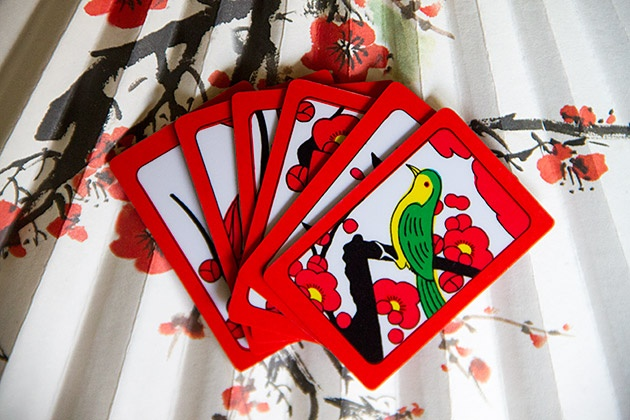

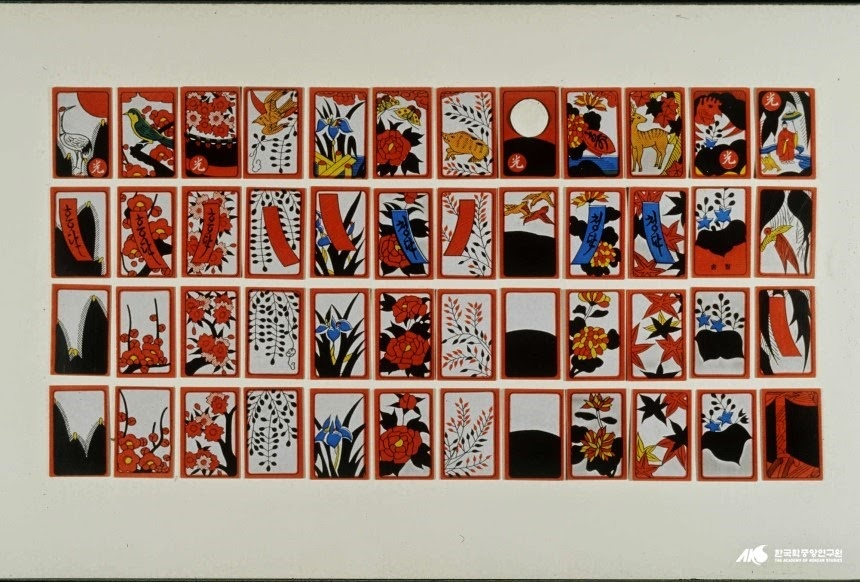

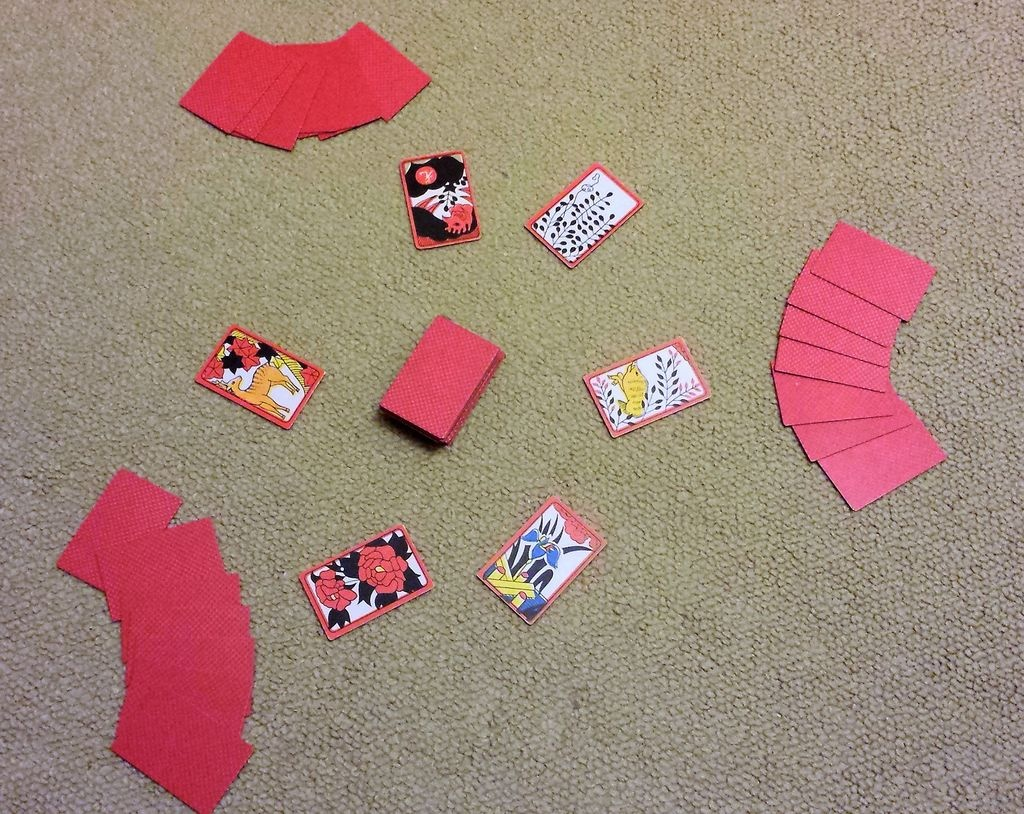

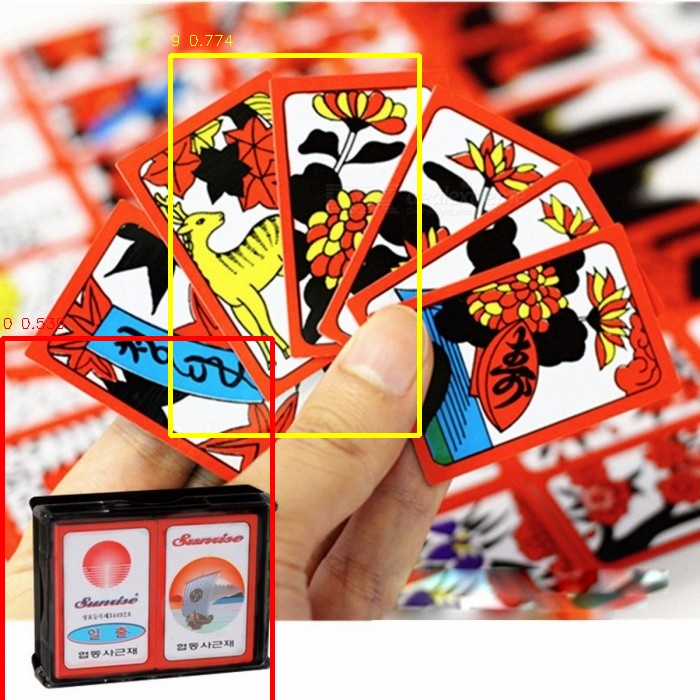

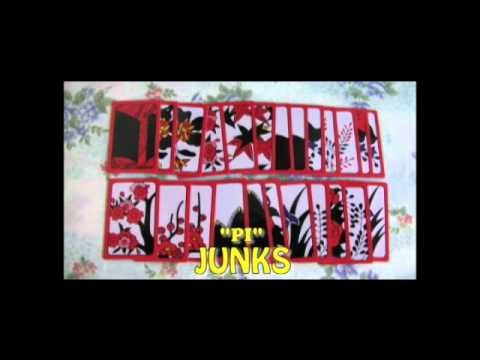

In [12]:
# visualize
from IPython.display import Image, display
import os
import random 

images = [f for f in os.listdir("./test-out/") if f.lower().endswith(".jpg")]
for i in random.sample(images, min(len(images), 5)): # show 5, at max, random images only
  display(Image("./test-out/{}".format(i), width=128, height=128))

## Appendix

In [13]:
# check if running on CPU/GPU/TPU
import tensorflow as tf
print(tf.test.gpu_device_name())
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1138688461771174488
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5058435322430879264
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
